HW3

In [1]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
!pip install pyfolio
import pyfolio as pf
import scipy.optimize as sco
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams['lines.linewidth'] = 1
warnings.simplefilter(action='ignore', category=FutureWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 11.0 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91 kB 4.2 MB/s 
     |████████████████████████████████| 52 kB 568 kB/s 
     |████████████████████████████████| 1.6 MB 31.8 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88681 sha256=dda9e4be24fa9594294be41337d5a00db6becd9f1956d0626ec4ba6b748f2b31
  Stored in directory: /root/.cache/pip/wheels/42/16/92/9c9d49efccc497040268960f0825101cc9b1c6e41cdc5a409e
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39778 sha256=4e3c3

/usr/local/lib/python3.8/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
n_assets = len(RISKY_ASSETS)

In [3]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
N_DAYS=len(prices_df)

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


In [4]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [5]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w) 
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility 
    return -portf_sharpe_ratio
def port_vol(w, avg_rtns, cov_mat, rf_rate):
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    return portf_volatility

In [6]:
n_assets = len(avg_returns)
RF_RATE = 0
args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x)-1})
bounds = tuple((0,1) for asset in range(n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args, 
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)
min_vol_portf = sco.minimize(port_vol,
                                x0=initial_guess,
                                args=args, 
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)

In [7]:
max_sharpe_portf

     fun: -0.7537885533444003
     jac: array([6.83071434e-01, 1.22896693e+00, 7.45058060e-09])
 message: 'Optimization terminated successfully'
    nfev: 8
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.00000000e+00, 1.66533454e-16, 1.00000000e+00])

In [8]:
min_vol_portf

     fun: 0.22490601723128853
     jac: array([0.22489803, 0.2249122 , 0.22489543])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.27957427, 0.587899  , 0.13252673])

HW4

In [9]:
RISKY_ASSET = 'MSFT'
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

In [10]:
df = yf.download(RISKY_ASSET, start=START_DATE, 
                 end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 completed
Downloaded 250 rows of data.


In [11]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()

In [12]:
train = returns['2018-01-01':'2018-11-30']
test = returns['2018-12-01':'2018-12-31']

In [13]:
T = len(test)
N = len(test) 
s_0 = adj_close[train.index[-1]]
N_SIM = 100 
mu = train.mean()
sigma = train.std()

In [14]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):

    np.random.seed(random_seed)

    dt = T/N   ## Zi  
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))#------ [Z1,Z2,Z3...]*시뮬레이션 여러번
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

In [15]:
gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

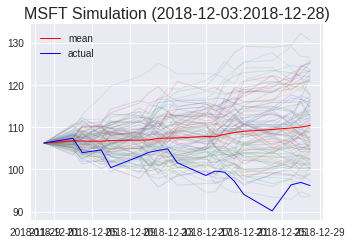

In [16]:
# prepare objects for plotting 
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
#plt.savefig('images/ch6_im2.png')
plt.show()